In [78]:
%load_ext autoreload
%autoreload 2

SAVE_DIR = '../figures/'
DATA_DIR = '../data/'

# Explore the columns of data and find outliers
import pandas as pd
import os
import os.path as osp
from typing import Optional
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# Visualization configuration
SAVE_EXTENSION = '.png'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())

# Update the font
plt.rcParams["font.family"] = "serif"

# Update the plt savefig path
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = SAVE_EXTENSION
plt.rcParams["savefig.directory"] = SAVE_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Regional Correlation Visualizations

In [2]:
import pickle
CORRELATION_PICKLE_PATH = osp.join(DATA_DIR,'correlations/correlations_2017_2022_top_200.pickle')
PICKLE_LABEL = '2017_2022_top_200'
assert os.path.exists(CORRELATION_PICKLE_PATH), 'Check the pathing to the correlation pickle file'

# Load the data
with open(CORRELATION_PICKLE_PATH, 'rb') as f:
    df = pickle.load(f)

In [3]:
# This seperation is predefined while saving the pickle
df_corr = {k:v[0] for k,v in df.items()}
df_spearman = {k:v[1] for k,v in df.items()}
df_kendall = {k:v[2] for k,v in df.items()}

In [98]:

def plot_correlation(df : pd.DataFrame, 
                     method : str ="Pearson",
                     show_extremes: bool = True,
                     save_path : Optional[str] = None,
                     show : bool = True,
                     **plot_kwargs
                     ):
    """
    Plots the correlation between popularity and audio features for different regions.

    Parameters:
    - df: DataFrame or Series
        The data containing the correlation values between popularity and audio features for different regions.
    - method: str, optional
        The label for the correlation method. Default is "Pearson".
    - show_extremes: bool, optional
        Whether to annotate the extreme correlation values with the corresponding region. Default is True.
    - save_path: str, optional
        The file path to save the plot. If not provided, the plot will not be saved.
    - **plot_kwargs: keyword arguments
        Additional keyword arguments to customize the plot.

    Returns:
    None
    """
    def _annotate_extremes(df):
        max_values = df.iloc[1:, :].T.idxmax()
        for feature, country in max_values.items():
            max_corr = df.loc[feature, country]
            plt.annotate(country, xy=(feature, max_corr), xytext=(-5, 10), textcoords='offset points', fontsize=12)

        min_values = df.iloc[1:, :].T.idxmin()
        for feature, country in min_values.items():
            min_corr = df.loc[feature, country]
            plt.annotate(country, xy=(feature, min_corr), xytext=(-5, -22), textcoords='offset points',fontsize=12)
            
    plt.figure(figsize=(12, 8))
    if isinstance(df, pd.Series):
        df = pd.DataFrame(df)


    # Add violin plot for each audio features
    for i, feature in enumerate(df.index[1:]):
        plt.violinplot(dataset=df.loc[feature, :].values[1:], positions=[i], showmeans=True, showextrema=True)

    for region in df.columns:
        corr = df[region]
        plt.scatter(x = corr[1:].index, y = corr[1:].values, alpha = 0.5, label = region, marker='o', **plot_kwargs) # Skip because first value is 1.0 always



    if show_extremes:
        _annotate_extremes(df)

    plt.legend(loc='upper right')
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(f"{method} correlation between popularity and audio features", fontsize=12)
    plt.ylabel("Correlation", fontsize=12)
    plt.xlabel("Audio feature", fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.gca().get_legend().remove()
    save_plot(save_path)

    # Close the figure so that it does not show up in the notebook
    if not show:
        plt.close()

def save_plot(save_path):
    if save_path is not None:
        plt.savefig(save_path)

def plot_mean_std_correlation(df, save_path=None, legends: Optional[list] = None, show : bool = True):
    plt.figure(figsize=(12,8))
    if isinstance(df, pd.Series):
        df = pd.DataFrame(df)

    if not isinstance(df, list):
        df = [df]

    for _df in df:
        mean_corr = _df.mean()[1:]
        std_corr = _df.std()[1:]

        plt.errorbar(mean_corr.index, mean_corr.values, yerr=std_corr.values, linestyle='-', marker='o')

        plt.xticks(rotation=45, fontsize=12)
        plt.yticks(fontsize=12)
        plt.title("Mean and Standard Deviation of Correlations", fontsize=14)
        plt.ylabel("Correlation", fontsize=12)
        plt.xlabel("Audio feature", fontsize=12)
        plt.grid(True)
        plt.tight_layout()

    if legends is not None:
        plt.legend(legends, loc='upper right', fontsize=12)

    save_plot(save_path)
        
    # Close the figure so that it does not show up in the notebook
    if not show:
        plt.close()
    

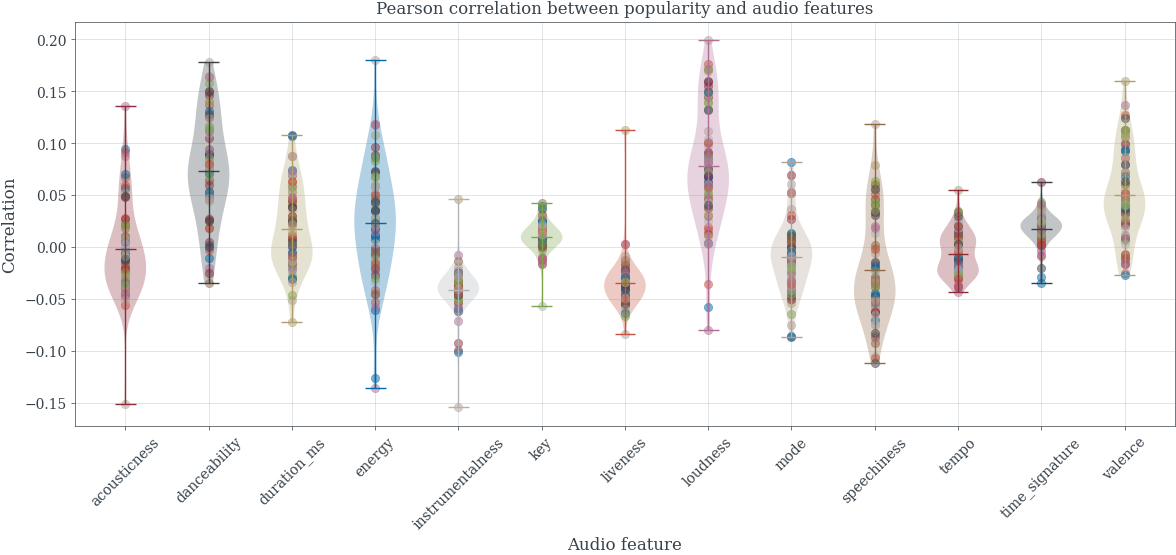

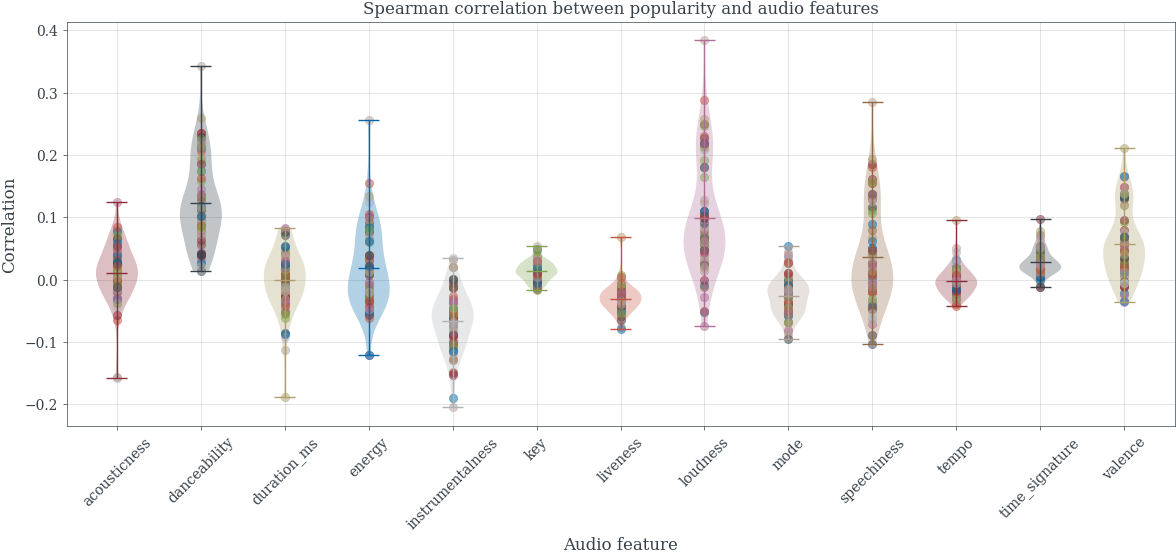

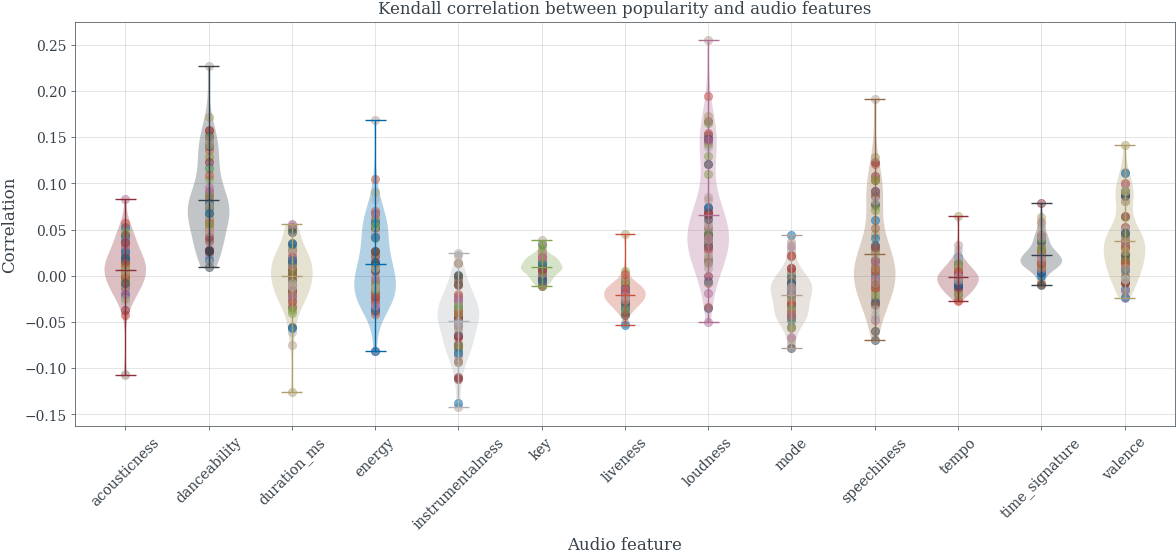

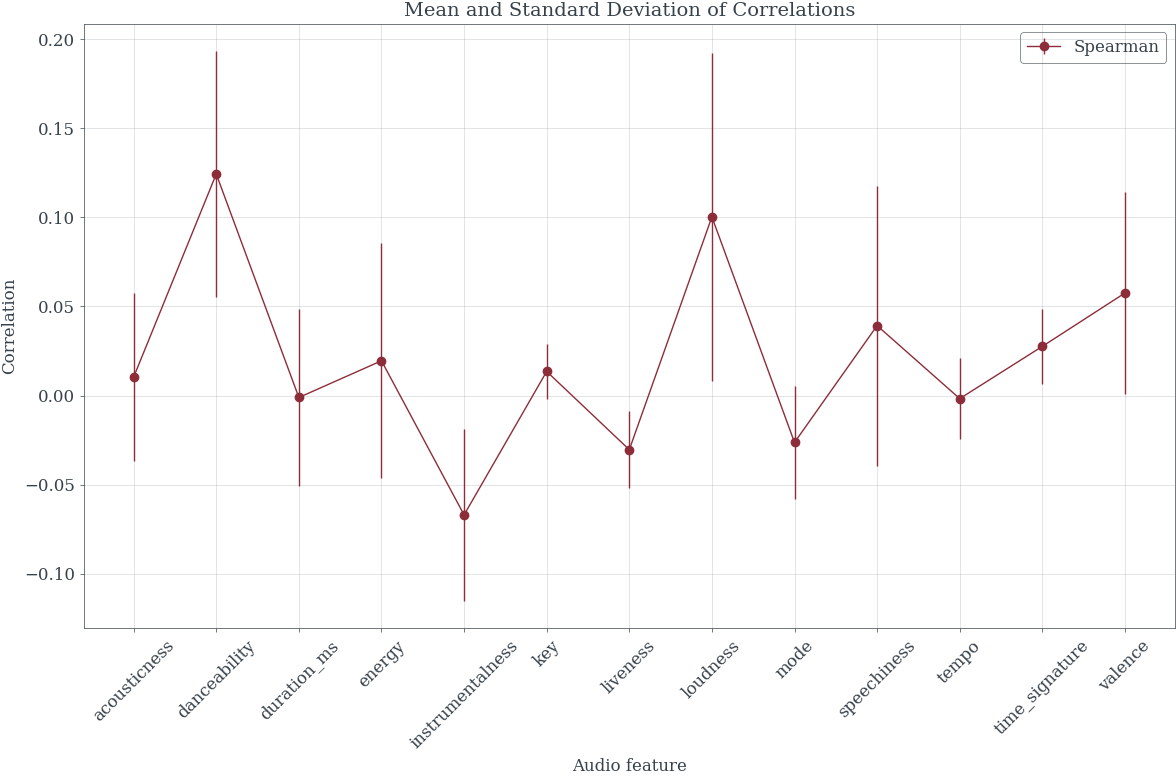

In [99]:
# Plot the correlation of Global Top200 charts
# plot_correlation(pd.DataFrame(df_corr)["Global"], show_extremes=False,
#                  save_path=osp.join(SAVE_DIR, 'corr_plots', f'correlation_global_{PICKLE_LABEL}{SAVE_EXTENSION}'))

# Plot the correlation of all regions
for label, df in zip(["Pearson", "Spearman", "Kendall"], [df_corr, df_spearman, df_kendall]):
    plot_correlation(pd.DataFrame(df), method=label, show_extremes=False,
                    save_path=osp.join(SAVE_DIR, 'corr_plots', f'correlation_{label.lower()}_{PICKLE_LABEL}{SAVE_EXTENSION}'))
    
# Plot the mean and std of all regions
plot_mean_std_correlation([pd.DataFrame(df_spearman).T.drop("Global")],
                          save_path=os.path.join(SAVE_DIR,'corr_plots',f"mean_std_correlation_{PICKLE_LABEL}{SAVE_EXTENSION}"), legends = ["Spearman"])

## Map Visualization


Visualizing everything on maps gives us a better understanding for how regions are correlated within itself.

In [94]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Update the mapping for specific labels
country_map = {
    "United States" : "United States of America",
    'Dominican Republic': 'Dominican Rep.',
    'Czech Republic': 'Czechia',
    'Hong Kong' : 'China',
}

labels = ["Pearson", "Spearman", "Kendall"]
for df_corr_full,corr_label in zip([pd.DataFrame(df_corr), pd.DataFrame(df_spearman), pd.DataFrame(df_kendall)],labels):
    # Load the world map shapefile
    world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    # Merge the world map with your correlation data
    df_corr_full = pd.DataFrame(df_corr).T.reset_index().rename(columns={"index":"Country"}).fillna(0)


    df_corr_full['Country'] = df_corr_full['Country'].replace(country_map)

    # Create a mapping for unmatched labels
    unmatched_labels = set(world_map['name']) - set(df_corr_full['Country'])

    # Iterate over each audio feature
    for feature in df_corr_full.columns[2:]:
        # Merge the data with the world map
        merged_data = world_map.merge(df_corr_full[['Country', feature]], left_on='name', right_on='Country', how='left')


        # Plot the correlation on the world map
        fig, ax = plt.subplots(figsize=(15, 10))
        merged_data.plot(column=feature, cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

        # Make each unmatched label white on the map with outlinings
        for label in unmatched_labels:
            merged_data[merged_data['name'] == label].plot(color='white', edgecolor='0.8', linewidth=0.8, ax=ax)

        # Customize the plot
        ax.set_title(f'{corr_label} correlations between streams and {feature}')
        ax.axis('off')

        # Save the figure
        save_path = f'world_map_{corr_label}_streams_{feature}.jpg'
        plt.savefig(os.path.join(SAVE_DIR,"world_maps",save_path))
        plt.close()

        print(f'World map for {feature} saved as {save_path}')


World map for acousticness saved as world_map_Pearson_streams_acousticness.jpg
World map for danceability saved as world_map_Pearson_streams_danceability.jpg
World map for duration_ms saved as world_map_Pearson_streams_duration_ms.jpg
World map for energy saved as world_map_Pearson_streams_energy.jpg
World map for instrumentalness saved as world_map_Pearson_streams_instrumentalness.jpg
World map for key saved as world_map_Pearson_streams_key.jpg
World map for liveness saved as world_map_Pearson_streams_liveness.jpg
World map for loudness saved as world_map_Pearson_streams_loudness.jpg
World map for mode saved as world_map_Pearson_streams_mode.jpg
World map for speechiness saved as world_map_Pearson_streams_speechiness.jpg
World map for tempo saved as world_map_Pearson_streams_tempo.jpg
World map for time_signature saved as world_map_Pearson_streams_time_signature.jpg
World map for valence saved as world_map_Pearson_streams_valence.jpg
World map for acousticness saved as world_map_Spear

### Similarity of Correlations
There seems to be a pattern of correlations as shown in the world-map plots. For example South America seems to have a similar tendencies for listening a song more based on a specific choice of audio feature scores

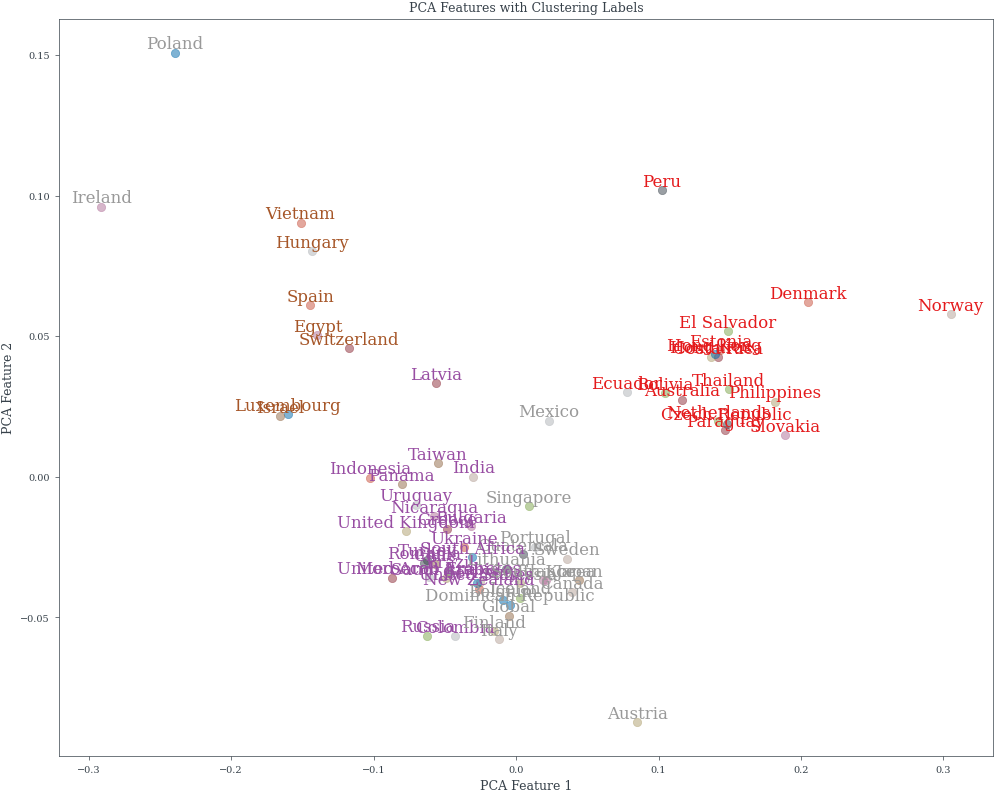

In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans,DBSCAN, MeanShift, AffinityPropagation

test_df = pd.DataFrame(df_corr)

# Apply PCA to get the first two principal components
pca = PCA(n_components=2)

# Fit the PCA model to the data
pca_features = pca.fit_transform(test_df.T.iloc[:,1:])

# Visualize the PCA features
plt.figure(figsize=(10, 8))

# Cluster the pca_features
kmeans = KMeans(n_clusters=5)
kmeans.fit(pca_features)

# Get the labels for each region in a dictionary
labels = {region:label for region, label in zip(test_df.columns[1:], kmeans.labels_)}

# Plot the PCA features with colored clustering labels
for i, region in enumerate(test_df.columns[1:]):
    # Plot the PCA features
    plt.scatter(pca_features[i, 0], pca_features[i, 1], alpha=0.5)
    plt.text(pca_features[i, 0], pca_features[i, 1], region, ha='center', va='bottom', fontsize=12, color=plt.cm.Set1(labels[region] / 3.))

plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('PCA Features with Clustering Labels')
plt.show()


<Figure size 1500x1000 with 0 Axes>

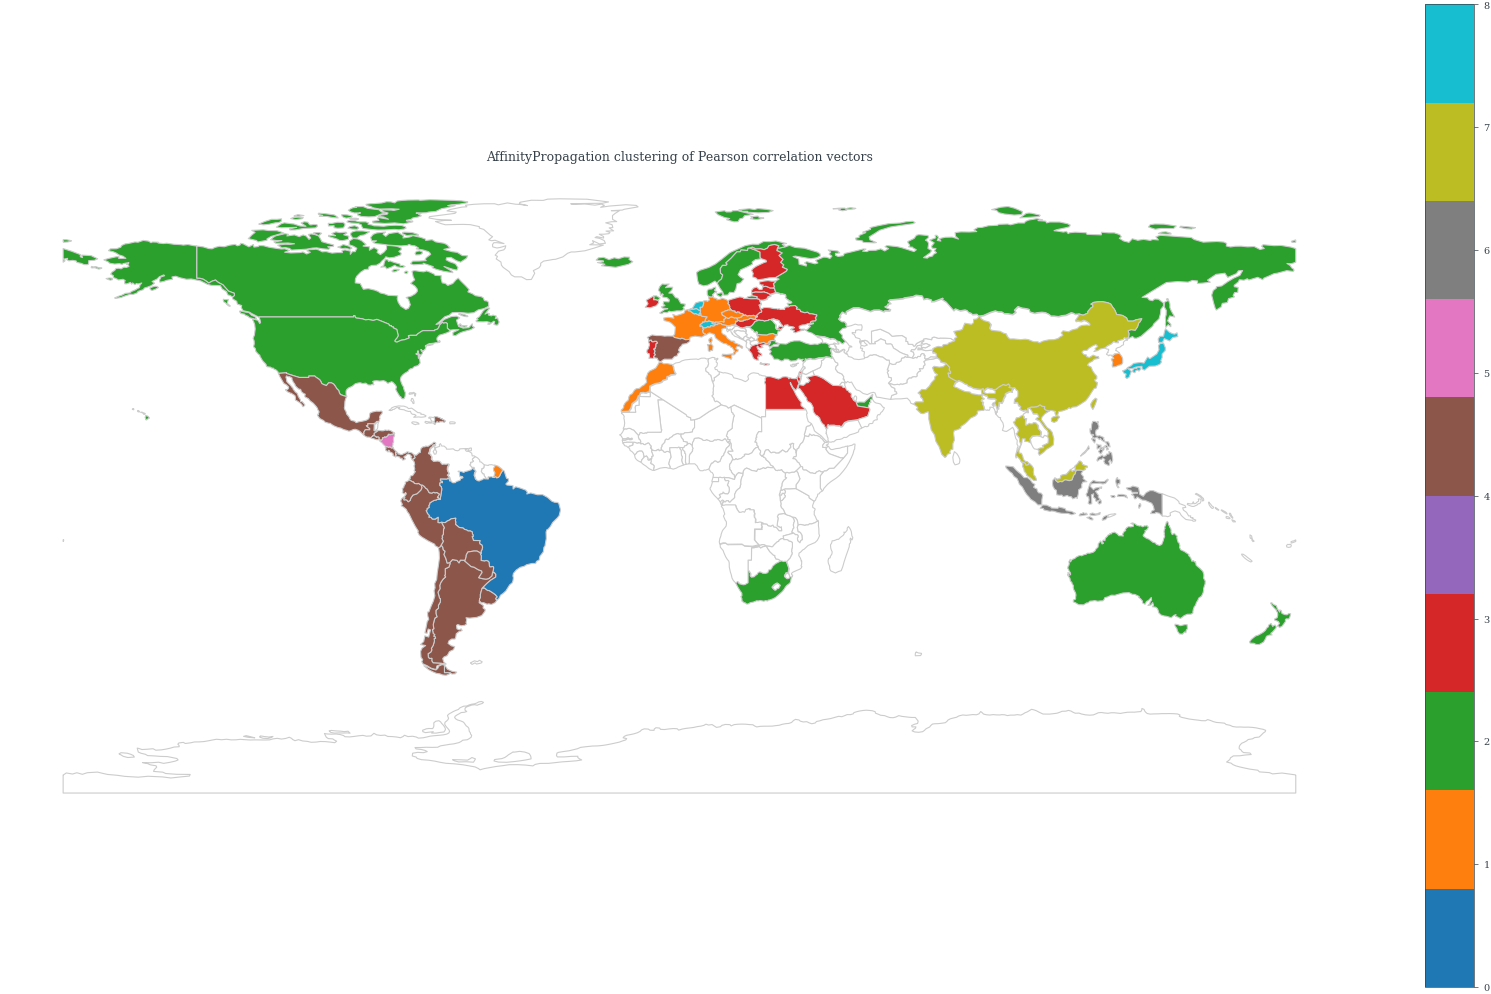

In [92]:
import geopandas as gpd
import difflib
import matplotlib.pyplot as plt
APPLY_DIM_REDUCTION = False
METHOD = "AffinityPropagation"

# Update the mapping for specific labels
country_map = {
    "United States" : "United States of America",
    'Dominican Republic': 'Dominican Rep.',
    'Czech Republic': 'Czechia',
    'Hong Kong' : 'China',
}

corr_labels = ["Pearson", "Spearman", "Kendall"]
for df_corr_full,corr_label in zip([pd.DataFrame(df_corr), pd.DataFrame(df_spearman), pd.DataFrame(df_kendall)],corr_labels):
    # Load the world map shapefile
    world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    # Merge the world map with your correlation data
    df_corr_full = pd.DataFrame(df_corr).T.reset_index().rename(columns={"index":"Country"}).fillna(0)

    
    df_corr_full['Country'] = df_corr_full['Country'].replace(country_map)

    # Create a mapping for unmatched labels
    unmatched_labels = set(world_map['name']) - set(df_corr_full['Country'])

    # Apply PCA to get the first two principal components
    if APPLY_DIM_REDUCTION:
        pca = PCA(n_components=2)

        # Fit the PCA model to the data
        pca_features = pca.fit_transform(df_corr_full.iloc[:,2:])
        fv = pca_features
    else:
        fv = df_corr_full.iloc[:,2:].values

    # Cluster the pca_features
    if METHOD == "KMeans":
        kmeans = KMeans(n_clusters=5, random_state=42)
        kmeans.fit(fv)
        df_corr_full['cluster_label'] = kmeans.labels_
    elif METHOD == "AffinityPropagation":
        affinity_propagation = AffinityPropagation(random_state=42)
        affinity_propagation.fit(fv)
        df_corr_full['cluster_label'] = affinity_propagation.labels_
    elif METHOD == "MeanShift":
        mean_shift = MeanShift(max_iter=500)
        mean_shift.fit(fv)
        df_corr_full['cluster_label'] = mean_shift.labels_
        
    plt.figure(figsize=(15, 10))

    # Merge the data with the world map
    merged_data = world_map.merge(df_corr_full[['Country', 'cluster_label']], left_on='name', right_on='Country', how='left')


    # Plot the correlation on the world map
    fig, ax = plt.subplots(figsize=(15, 10))
    merged_data.plot(column='cluster_label', cmap='tab10', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

    # Remove the all colors without a label on dataset

    # Make each unmatched label white on the map with outlinings
    for label in unmatched_labels:
        merged_data[merged_data['name'] == label].plot(color='white', edgecolor='0.8', linewidth=0.8, ax=ax)

    # Remove the colorbar
    ax.set_title(f'{METHOD} clustering of {corr_label} correlation vectors')
    ax.axis('off')

    # Save the figure
    plt.show()
    break
    # save_path = f'world_map_clustering_{corr_label}_popularity.jpg'
    # plt.savefig(os.path.join(SAVE_DIR,"world_maps",save_path))
    # plt.close()



## Conclusion
It seems that many of the countries has weak-moderate correlations in their top-charts. Although this correlation is not strong, this founding shows that audio features do have some effects on different countries and their preferences.